Make Functions Work for Classification Export 41


In [69]:
import os
import pandas as pd
import numpy as np
from fancyimpute import IterativeImputer
from datetime import datetime

# Data exploration

Apply Machine Learning: I ran this on Google Colab

In [70]:


import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Read the file
df_41 = pd.read_csv('./Export 41 and weather.csv') #, nrows = 25000

# Define x and y
x = df_41[['hour', 'month', 'weekday', 'description', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_TEMP_QCL0']]
#'hour', 'month', 'weekday', 'description', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0', 'LC_TEMP_QCL1', 'LC_TEMP_QCL2', 'LC_TEMP_QCL3'
y = df_41['noise_event_laeq_primary_detected_class']



<AxesSubplot:title={'center':'Count (target)'}>

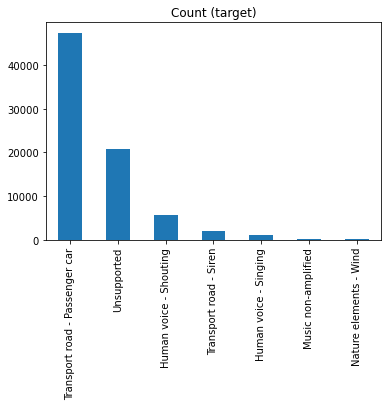

In [71]:


y.value_counts().plot(kind='bar', title='Count (target)')

#We see that the target variable is highly imbalanced, but there're 7 categories overall and 
#replicating new data with resampling will end up with reseampled data prevailing actual data, so we leave as it is

In [72]:
correlations = x.corr()
correlations

#no correlations > 0.9, so we keep all variables

,hour,month,weekday,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_WINDDIR,LC_WINDSPEED,LC_TEMP_QCL0
hour,1.000000,0.015983,0.009000,-0.334851,0.093846,-0.002903,-0.019561,0.120020,0.272212
month,0.015983,1.000000,0.073404,0.354403,0.151760,0.082337,-0.076921,-0.147478,-0.077921
weekday,0.009000,0.073404,1.000000,0.040522,-0.003441,-0.001092,0.028852,-0.005573,-0.026779
LC_HUMIDITY,-0.334851,0.354403,0.040522,1.000000,-0.133804,0.014805,-0.156759,-0.212346,-0.709729
LC_DWPTEMP,0.093846,0.151760,-0.003441,-0.133804,1.000000,0.107235,-0.191764,-0.001571,0.782228
LC_n,-0.002903,0.082337,-0.001092,0.014805,0.107235,1.000000,-0.059735,0.006572,0.073607
LC_WINDDIR,-0.019561,-0.076921,0.028852,-0.156759,-0.191764,-0.059735,1.000000,-0.324780,-0.032301
LC_WINDSPEED,0.120020,-0.147478,-0.005573,-0.212346,-0.001571,0.006572,-0.324780,1.000000,0.114039
LC_TEMP_QCL0,0.272212,-0.077921,-0.026779,-0.709729,0.782228,0.073607,-0.032301,0.114039,1.000000


Text(0.5, 1.0, 'Distribution of LC_HUMIDITY')

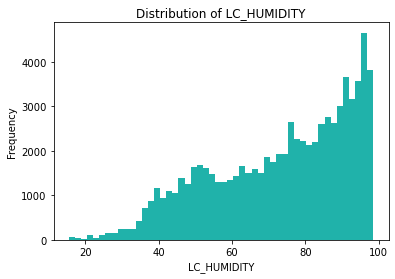

In [73]:
from matplotlib import pyplot as plt

#checking data distribution
plt.hist(x['LC_HUMIDITY'],bins=50,color='lightseagreen')
plt.xlabel('LC_HUMIDITY')
plt.ylabel('Frequency')
plt.title('Distribution of LC_HUMIDITY')

#the plot is skewed to the left

Text(0.5, 1.0, 'Distribution of wind speed')

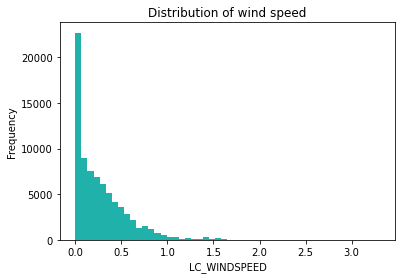

In [74]:
plt.hist(x['LC_WINDSPEED'],bins=50,color='lightseagreen')
plt.xlabel('LC_WINDSPEED')
plt.ylabel('Frequency')
plt.title('Distribution of wind speed')

#the plot is skewed to the left

Text(0.5, 1.0, 'Distribution of wind speed')

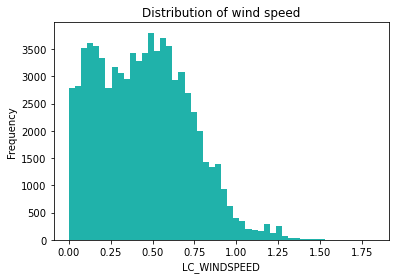

In [75]:
#let's take root square to deal with skewness

plt.hist(np.sqrt(x['LC_WINDSPEED']),bins=50,color='lightseagreen')
plt.xlabel('LC_WINDSPEED')
plt.ylabel('Frequency')
plt.title('Distribution of wind speed')

## Preprocessing

In [78]:
# Initialise the label encoders

label_encoder_x = LabelEncoder()
label_encoder_y = LabelEncoder()

# Encode the 'description' feature as class
x.loc[:, 'description'] = label_encoder_x.fit_transform(x['description'])

# Encode the target variable
y_encoded = label_encoder_y.fit_transform(y)

#building a pipeline to scale numerical features and make normally distributed
scale_pipe = make_pipeline(MinMaxScaler(),QuantileTransformer(output_distribution='normal') )

#selecting only numerical columns (not categories)
num_cols = list(x.drop(['description', 'weekday', 'hour', 'month'], axis=1).columns)


transformer = ColumnTransformer(
    transformers=[
        ("scale", scale_pipe, num_cols)
    ], remainder='passthrough'
)

#transforming whole data
cnames = list(x.columns)
x_transformed= pd.DataFrame(transformer.fit_transform(x), columns=cnames)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_transformed, y, test_size=0.25, random_state=42)

#parameters to pass to random forest
params2 = { 'max_depth': [5,15],
           'min_samples_split': [2, 10],
           'n_estimators': [100, 500],
           'min_samples_leaf': [5]}

forest = RandomForestClassifier(max_depth=6, random_state=42)

#make kfold strat
#cv = KFold(n_splits=3, random_state=1, shuffle=True)

#grid serach to find best parameters for random forest classifier
clf = GridSearchCV(forest, param_grid=params2, verbose = 1,  n_jobs = -1)




/Users/zarina/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Model evaluation

In [79]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score




# evaluate model
clf.fit(x_train, y_train)
#scores = cross_val_score(forest1, x_train, y, scoring='accuracy', cv=cv)
final_clf = clf.best_estimator_

# report performance
#print('Accuracy for RandomForest: %.3f (%.3f)' % (mean(scores), std(scores)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [80]:
final_clf

RandomForestClassifier(max_depth=15, min_samples_leaf=5, random_state=42)

In [83]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = final_clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print("Test Accuracy: ", score)
confusion_matrix(y_test, y_pred)

Test Accuracy:  0.6780257910818789


array([[  397,     0,     0,     0,   721,    10,   323],
       [    2,    10,     0,     0,   153,     0,    91],
       [   10,     0,     0,     0,    23,     0,     6],
       [    0,     0,     0,     0,    29,     0,     5],
       [   72,     0,     0,     0, 11388,     5,   413],
       [   14,     0,     0,     0,   377,    27,    65],
       [  147,     7,     0,     0,  3742,     2,  1270]])

In [85]:
y_train_pred = final_clf.predict(x_train)
score_train = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:",score_train)


Train Accuracy: 0.719775571860164
Importances: [0.1031686  0.11037769 0.07850852 0.08570643 0.094888   0.10757812
 0.18429582 0.10085539 0.04692682 0.0876946 ]


<AxesSubplot:>

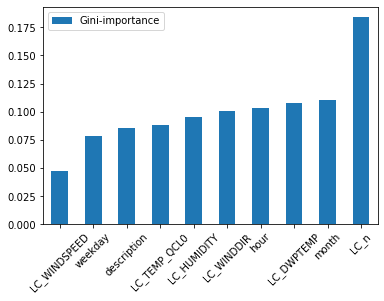

In [96]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, final_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

#plot features by their importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

Results of the Application of Random Forests on Noise 41 and Weather

Train Accuracy: 0.72
Test Accuracy: 0.68
We found out than LC_n is the most important feature according to the model (meaning that feature splits the data with highest gini impurity)
 
Test accuracy is lower than train accuracy as usual, but not critically lower. We have improved the test accuracy with improving pre-processing texhniques, like transformating to follow normal distribution, scaling, etc.

In [93]:
final_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}